In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Trading in V3
In this note, we discuss the idea of trading behind Uniswap V3. Write $[0,\infty) = \bigcup_{i=0}^\infty [P_i , P_{i+1}] \equiv \bigcup_{i=0}^\infty I_i$. Given $Z \in I_i$ and $\bar{Z} \in I_k$ with
$l \leq k$ and $0 < Z \leq \bar{Z}$, we use the notations $(x_i,y_i)=R_3(I_i,L_i,Z)$, $(x_k,y_k)=R_3(I_i,L_i,\bar{Z})$, $(0,y^*_j) = R_3(I_j,L_j,P_{j})$, $(x^*_j,0) = R_3(I_j,L_j,P_{j+1})$ for
$i\leq j\leq k$ and define the following quantities:
- **Amount of $Y$ reserves** between 
    $Z$ and $\bar{Z}$: $r_Y(Z , \bar{Z}) \equiv y_i+\sum^{k-1}_{j=i+1}y^*_j +y^*_k - y_k$
- **Amount of $X$ reserves** between
     $Z$ and $\bar{Z}$: $r_X(Z, \bar{Z}) \equiv x_k+ \sum^{k-1}_{j=i+1}x^*_j+ x^*_i-x_i $

The summation vanishes if $k=i$. One can write the liquidity as a step function of the pool price:
- $$L(Z) \equiv \sum^\infty_{i=0} L_i I_{[P_i,P_{i+1}]}(Z)$$
For simplicity, we assume that only on a compact interval $[P_{n_{min}},P_{n_{max}}] = \bigcup_{i=n_{min}}^{n_{max} -1} I_i$
the liquidity $L(z)$ is nonzero (i.e only $\{L_i\}_{i=n_{min}}^{n_{max} -1}$ is nonzero).When $Z \in [P_i , P_{i+1}]$, the reserves on that tick can be expressed as integrals:
- $$ x_i = L_i( \sqrt{Z} - \sqrt{P}_i) = \int_{P_i}^{Z} \frac{1}{2} L(t)t^{-\frac{1}{2}} dt$$
- $$ y_i = L_i( \frac{1}{\sqrt{Z}} - \frac{1}{\sqrt{P}_{i+1}}) 
= \int_{Z}^{P_{i+1}} \frac{1}{2} L(t)t^{-\frac{3}{2}} dt$$
Same for the quantities, the amount of the reserves we defined above:
- $$r_X(Z , \bar{Z}) = \int_{Z}^{\bar{Z}} \frac{1}{2} L(t)t^{-\frac{1}{2}} dt$$
- $$r_Y(Z , \bar{Z}) = \int_{Z}^{\bar{Z}} \frac{1}{2} L(t)t^{-\frac{3}{2}} dt$$

Buying $\Delta y >0$ amount of asset $Y$ from the pool can be considered as  a mapping that maps the current pool price $Z$ to the new pool price $\bar{Z}$ that is given by:
$$
\bar{Z} \equiv \inf\{s^*>Z \mid r_Y(Z,s^*)= \Delta y \wedge y_{max}\}
=\begin{cases}
    P_{n_{max}}  & \text{if} \; \Delta y \geq y_{max}
    \\
    \inf\{s^*>Z \mid r_Y(Z,s^*)= \Delta y\} 
    & \text{if} \; \Delta y < y_{max}
\end{cases} 
$$
where $y_{max} = r_Y(Z,P_{n_{max}\;})$ is the current total amount of $Y$ reserves in the pool and $[P_{n_{max}\;\,-1} ,P_{n_{max}\;}]$ is the right most tick that has nozero liquidity. Similary, selling $\Delta y >0$ amount of asset $Y$ to the pool
pushes the the pool price to $\bar{Z}$ given by:
$$
\bar{Z} \equiv 
\sup\{s^*< \bar{Z} \mid r_Y(s^*,\bar{Z})=\gamma\Delta y \wedge \bar{y}_{max}\}
=\begin{cases}
    P_{n_{min}}  
    & \text{if} \;  \gamma\Delta y \geq \bar{y}_{max}
    \\
    \sup\{s^*<\bar{Z} \mid r_Y(s^*,\bar{Z})\geq \gamma\Delta y\} 
    & \text{if} \; \gamma\Delta y=\bar{y}_{max}
\end{cases} 
$$
where $\gamma>0$ is the fee constant.

### Code

Parameters:
- ```S_pool```: The current pool price.
- ```ticks_array```: An array that consists of tick prices $\{P_i\}_{i \geq 0}$ sepcifying all ticks $I_i = [P_i , P_{i+1}]$ that have liquidity. We expected it to be bounded away from zero.

Functions:
- ```activated_ticks_index```: Given the current pool price, return the index of the tick where the the price locates. This index is w.r.t the given ticks array. e.g $Z \in [P_i,P_{i+1}]$ , returns the index of $P_i$ in the ```ticks_array```.

In [13]:
def activated_ticks_index(S_pool,ticks_array):
    left, right = 0, len(ticks_array) - 1
    while left <= right:
        mid = (right + lef t) // 2
        if mid == len(ticks_array) - 1:
            if S_pool ==ticks_array[mid]:
                return mid
            else: #S_pool outside of the given range
                break
        else:   
            if ticks_array[mid] <= S_pool < ticks_array[mid + 1]:
                return mid  
            elif S_pool < ticks_array[mid]:
                right = mid - 1
            else:
                left = mid + 1
    return -1  

Parameters:
- ```S_pool_0```: Lower pool price for computing $r_X$ and $r_Y$.
- ```S_pool_1```: Upper pool price for computing $r_X$ and $r_Y$.
- ```L_array```: An array that consists of the liquidity on each tick (corresponding to ```ticks_array```). 

Functions:
- ```r_X```: Compute the amount of $X$ reserves between two given prices.
- ```r_Y```: Compute the amount of $Y$ reserves between two given prices.

In [14]:
def r_X(S_pool_0 , S_pool_1 , L_array,ticks_array):
    if S_pool_0 > S_pool_1:
        print("error!first argument should be smaller than the second!")
    index_0= activated_ticks_index(S_pool_0,ticks_array)
    index_1= activated_ticks_index(S_pool_1,ticks_array)
    if index_0 ==-1 or index_1 ==-1:
        print("error!outside of tick range!")
        
    amount =0
    for i in range(index_0 ,index_1+1):
        if i == index_0:
            amount+=L_array[i]*(np.sqrt(ticks_array[i+1])-np.sqrt(S_pool_0) )
        elif i == index_1:
            amount+= L_array[i]*( np.sqrt(S_pool_1) - np.sqrt(ticks_array[i])  ) 
        else:
            amount+=L_array[i]*( np.sqrt(ticks_array[i+1]) - np.sqrt(ticks_array[i])  )
    return amount

def r_Y(S_pool_0 , S_pool_1,L_array,ticks_array):
    if S_pool_0 > S_pool_1:
        print("error!first argument should be smaller than the second!")

    index_0= activated_ticks_index(S_pool_0,ticks_array)
    index_1= activated_ticks_index(S_pool_1,ticks_array)
    if index_0 ==-1 or index_1 ==-1:
        print("error!outside of tick range!")
    amount =0
    for i in range(index_0 ,index_1+1):
        if i == index_0:
            amount += L_array[i]*( 1/np.sqrt(S_pool_0) - 1/np.sqrt(ticks_array[i+1]) )
        elif i == index_1:
            amount += L_array[i]*( 1/np.sqrt(ticks_array[i]) - 1/np.sqrt(S_pool_1)  )
        else:
            amount += L_array[i]*( 1/np.sqrt(ticks_array[i]) - 1/np.sqrt(ticks_array[i+1]) ) 
    return amount

From the above we note that $r_X(Z_0,\cdot)$ and $r_Y(Z_0,\cdot)$ can be expressed as the integral of some
density $$d_X(z) = \frac{1}{2}L(z)z^{-\frac{1}{2}} \; , \; d_Y(z) = \frac{1}{2}L(z^*)z^{-\frac{3}{2}}$$

In [47]:
def d_X(z,L_array,ticks_array):
    i=activated_ticks_index(z,ticks_array)
    if i==-1:
        return 0
    else:
        return 1/2*L_array[i]*z**(-1/2)
def d_Y(z,L_array,ticks_array):
    i=activated_ticks_index(z,ticks_array)
    if i==-1:
        return 0
    else:
        return 1/2*L_array[i]*z**(-3/2)

Parameters:
- ```delta_y```: The amount of asset $Y$ the trader wants to sell/buy. When the input is positive, the trader sells $Y$ to the pool. And when it is negative, the trader buys $Y$ from the pool.
- ```gamma```: The fee constant $ \gamma \in (0,1) $. 
- ```S_pool_ini```: The initial pool price when the trade is conducted.

Functions:
- ```trade```: Return a tuple consists of the amount of asset $X$ the trader receives/pays from the trade and the pool price after trade.
- ```trade_plot```: Plot the graph of ```d_X``` , ```d_Y``` and visualize the trade-related quantities on the plot, see the example later.

In [190]:
def trade(delta_y,gamma,S_pool_ini,L_array,ticks_array):
    index_ini = activated_ticks_index(S_pool_ini,ticks_array)
    if delta_y>=0: #sell Y
        sell=gamma*delta_y
        i=index_ini 
        S_pool = S_pool_ini
        while sell > 0: #trade tick-by-tick
            if i <0:  #not enough capacity for Y paid by the trader, equivalently , not enough X to pay the trader
                S_pool_fin = ticks_array[0]
                print("out of X reserves")
                break
            max_Y = r_Y(ticks_array[i], S_pool,L_array,ticks_array) #current max amount(capacity) of Y on the tick                
            if sell <= max_Y: #the trade finishes at this tick
                S_pool_fin=(1/np.sqrt(S_pool)+sell/L_array[i])**(-2)
                break
            else: 
                sell=sell-max_Y   #trader receives all X on that tick         
                S_pool = ticks_array[i] #pool price moves to the next tick
                i=i-1         
        return r_X(S_pool_fin,S_pool_ini,L_array,ticks_array) , S_pool_fin #the amount of X the trader receive and final pool price
    
    if delta_y<0: #buy y
        buy= -delta_y
        i=index_ini 
        S_pool = S_pool_ini
        while buy > 0: #trade tick-by-tick
            if i >=len(ticks_array)-1: #not enough Y to pay the trader
                S_pool_fin = ticks_array[-1]
                print("out of Y reserves")
                break
            max_Y = r_Y(S_pool,ticks_array[i+1],L_array,ticks_array) #current max amount(reserve) of Y on the tick                
            if buy <= max_Y: 
                S_pool_fin=(1/np.sqrt(S_pool)- buy/L_array[i])**(-2)
                break
            else: 
                buy=buy-max_Y  #trader buys all Y on that tick
                S_pool = ticks_array[i+1]  
                i=i+1   
        return gamma*r_X(S_pool_ini,S_pool_fin,L_array,ticks_array) , S_pool_fin #the amount of X the trader pay and final pool price
    


def trade_plot(delta_y,gamma,S_pool_ini,L_array,ticks_array):
    #delta: w.r.t the trader , change: w.r.t the pool
    if delta_y >= 0:
        change_x,S_pool_fin= trade(delta_y,gamma,S_pool_ini,L_array,ticks_array)
        change_y = r_Y(S_pool_fin,S_pool_ini,L_array,ticks_array)
        price_fill_array=np.linspace(S_pool_fin,S_pool_ini,1000)
        print(f'The area of blue shaded region in the graph of d_X is {change_x} ,the amount of X that the trader receives')
        print(f'The area of blue shaded region in the graph of d_Y is {change_y}, the amount of Y that the pool receives')      
    else:
        delta_x,S_pool_fin = trade(delta_y,gamma,S_pool_ini,L_array,ticks_array)
        change_x = gamma**(-1)*delta_x
        change_y = r_Y(S_pool_ini,S_pool_fin,L_array,ticks_array)
        price_fill_array=np.linspace(S_pool_ini,S_pool_fin,1000)
        print(f'The area of blue shaded region in the graph of d_X is {change_x} ,the amount of X that the trader receives')
        print(f'The area of blue shaded region in the graph of d_Y is {change_y},the amount of Y that the trader receives')
    #plotting
    fig,ax =plt.subplots(1,2,figsize=(16,6))
    P_0 = ticks_array[0]
    P_max= ticks_array[-1]
    price_array=np.linspace(P_0*0.9,P_max*1.1,10**4)
    d_X_array=[d_X(z,L_array,ticks_array) for z in price_array]
    d_Y_array=[d_Y(z,L_array,ticks_array) for z in price_array]
    d_X_fill_array=[d_X(z,L_array,ticks_array) for z in price_fill_array]
    d_Y_fill_array=[d_Y(z,L_array,ticks_array) for z in price_fill_array]
    
    ax[0].plot(price_array,d_X_array)
    ax[0].axvline(S_pool_ini,color='red',ls='--',alpha=0.6)
    ax[0].axvline(S_pool_fin,color='red',ls='--',alpha=0.6)
    ax[0].fill_between(price_fill_array,d_X_fill_array,alpha=0.4)
    ax[0].set_ylim(0)
    ax[0].set_xlabel('price')
    ax[0].set_ylabel('d_X',rotation=0)
    ax[0].set_xticks(ticks_array)
    ax[0].text( S_pool_ini, 0 , 'S_ini' ,ha = 'center',va='bottom' ,color='black',fontsize=10)
    ax[0].text(S_pool_fin, 0, 'S_fin',ha = 'center', va='bottom',color='black',fontsize=10)
    ax[0].set_title('density of X')
    ax[1].plot(price_array,d_Y_array)
    ax[1].axvline(S_pool_ini,color='red',ls='--',alpha=0.6)
    ax[1].axvline(S_pool_fin,color='red',ls='--',alpha=0.6)
    ax[1].fill_between(price_fill_array,d_Y_fill_array,alpha=0.4)
    ax[1].set_xlabel('price')
    ax[1].set_ylabel('d_Y',rotation=0)
    ax[1].set_ylim(0)
    ax[1].set_xticks(ticks_array)
    ax[1].text(S_pool_ini, 0, 'S_ini',ha = 'center',va='bottom',color='black',fontsize=10)
    ax[1].text(S_pool_fin, 0, 'S_fin',ha = 'center',va='bottom',color='black',fontsize=10)
    ax[1].set_title('density of Y')


### Examples

Let $I_i = [P_i , P_{i+1}] = [\frac{i}{10} , \frac{i+1}{10}]$  and 
$$
L_i=
\begin{cases}
1 & i=1 \sim 6, 14 \sim 21 \\
2 & i=7,13 \\
4 & i=8,9,11,12\\
8 & i=10 \\
0 & \text{otherwise}
\end{cases}
$$
. First we plot the liquidity w.r.t the pool price.

Text(0, 0.5, 'liquidity')

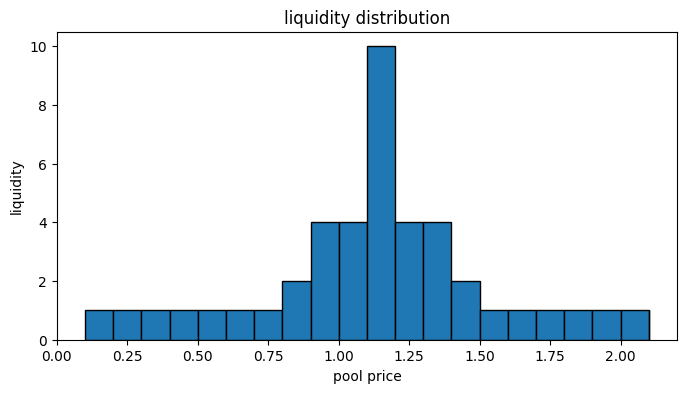

In [16]:
ticks_array=np.array([ i/10 for i in range(1,22)])
index = activated_ticks_index(1,ticks_array)
L_array = np.ones_like(ticks_array)
for i in range(len(L_array)-1):
    if i == 7 or i==13:
        L_array[i]=2
    if i ==8 or i==9 or i==11 or i==12:
        L_array[i]=4
    if i==10:
        L_array[i]=10
plt.figure(figsize=(8,4))
plt.bar(ticks_array , L_array , width =np.append(np.diff(ticks_array),0),align='edge',ec='black')
plt.title("liquidity distribution")
plt.xlabel("pool price")
plt.ylabel("liquidity")

Next we plot the functions $r_X(Z_0,\cdot)$ and $r_Y(Z_0,\cdot)$ w.r.t the pool price.

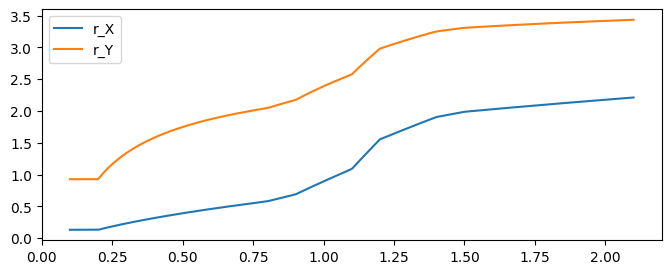

In [18]:
plt.figure(figsize=(8,3))

P_0 =ticks_array[0]
P_max = ticks_array[-1]
r_X_array = np.array([r_X(P_0 , s , L_array,ticks_array) for s in np.linspace(P_0,P_max,10**4)])
r_Y_array = np.array([r_Y(P_0 , s , L_array,ticks_array) for s in np.linspace(P_0,P_max,10**4)])
plt.plot(np.linspace(P_0,P_max,10**4),r_X_array,label="r_X")
plt.plot(np.linspace(P_0,P_max,10**4),r_Y_array,label="r_Y")
plt.legend()

We can try to use the graph of $d_X$ and $d_Y$ to visualize a trade

The area of blue shaded region in the graph of d_X is 0.5771445745702017 ,the amount of X that the trader receives
The area of blue shaded region in the graph of d_Y is 0.8108503569823691, the amount of Y that the pool receives


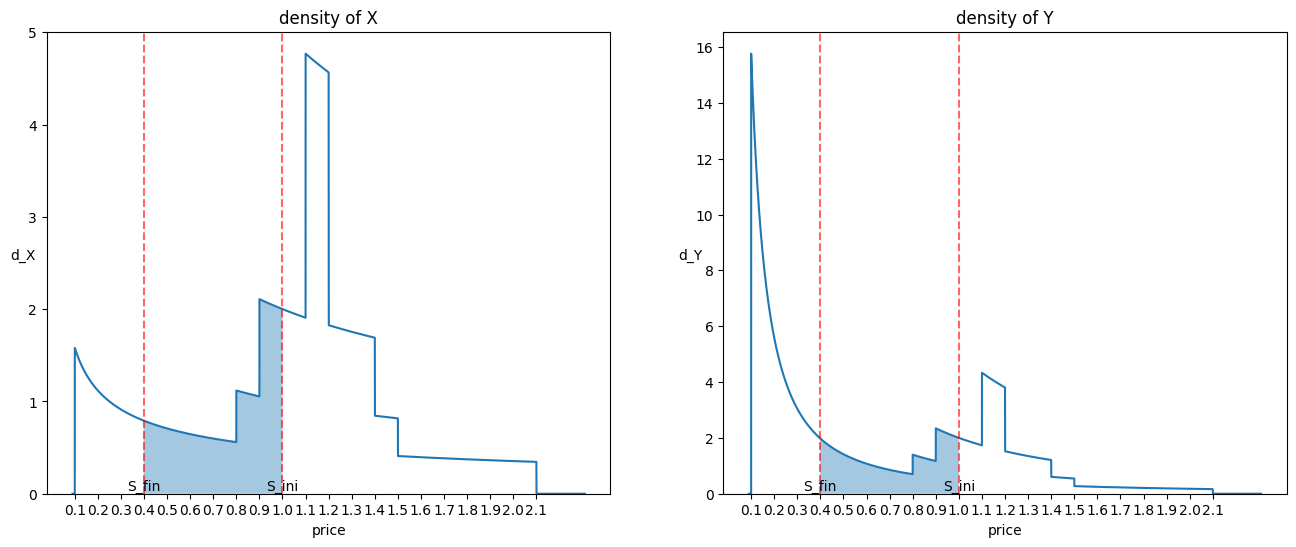

In [192]:
trade_plot(1,0.997,1,L_array,ticks_array)

out of Y reserves
The area of blue shaded region in the graph of d_X is 1.3201320602914624 ,the amount of X that the trader receives
The area of blue shaded region in the graph of d_Y is 1.0466793106947787,the amount of Y that the trader receives


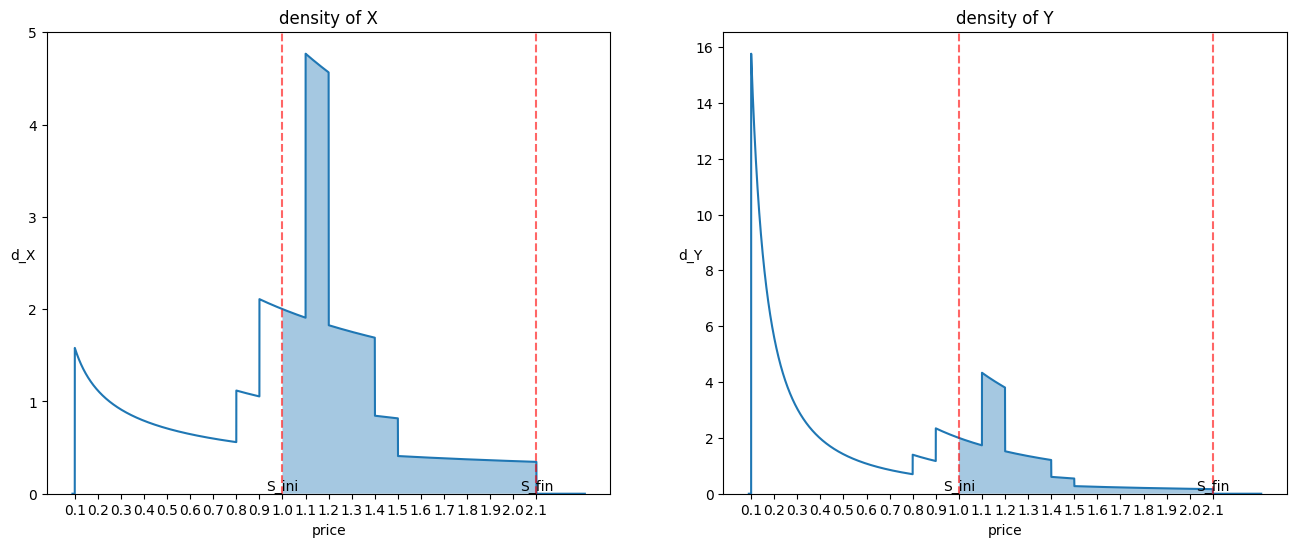

In [191]:
trade_plot(-5,0.997,1,L_array,ticks_array)